In [ ]:
import cv2
import numpy as np

from sklearn.metrics import pairwise

In [ ]:
background=None

accumulated_weight=0.5

roi_top=20
roi_bottom=100
roi_right=400
roi_left=400


In [ ]:
def cal_accum_avg(frame,accumulated_weight):
    global background
    
    if background is None:
        background=frame.copy().astype('float')
        return None
    cv2.accumulateWeighted(frame,background,accumulated_weight)

In [ ]:
def segment(frame,threshold_min=25):
    
    diff=cv2.absdiff(background.astype('uint8'),frame)
    
    ret,thresholded=cv2.threshold(diff,threshold_min,255,cv2.THRESH_BINARY)
    
    image,contours,heirarchy=cv2.findContours(thresholded.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours)==0:
        return None
    else:
        #assuming largest external contour in roi is hand
        hand_segmnet=max(contours,key=cv2.contourArea)
        
        return (thresholded,hand_segmnet)

In [ ]:
def count_fingers(thresholded,hand_segment):
    
    conv_hull=cv2.convexHull(hand_segment)
    
    
    top=tuple(conv_hull[conv_hull[:,:,1].argmin()][0])
    bottom=tuple(conv_hull[conv_hull[:,:,1].argmax()][0])
    left=tuple(conv_hull[conv_hull[:,:,0].argmin()][0])
    right=tuple(conv_hull[conv_hull[:,:,0].argmax()][0])
    
    cx=(left[0]+right[0])//2
    cy=(top[1]+bottom[1])//2
    
    distance=pairwise.euclidean_distances([(cx,cy)],Y=[left,right,top,bottom])[0]
    max_dist=distance.max()
    
    radius=int(0.9*max_dist)
    circumference=(2*np.pi*radius)
    
    circular_roi=np.zeros(thresholded.shape[:2],dtype="uint8")
    
    cv2.circle(circular_roi,(cx,cy),radius,255,10)
    
    circular_roi=cv2.bitwise_and(thresholded,thresholded,mask=circular_roi)
    
    image,contours,heirarchy=cv2.findContours(circular_roi.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    count=0
    for cnt in contours:
        
        (x,y,w,h)=cv2.boundingRect(cnt)
        out_of_wrist=(cy+(cy*0.25))>(y+h)
        
        limit_points=((circumference*25)>cnt.shape[0])
        
        if out_of_wrist and limit_points:
            count+=1
    return count

In [ ]:
cam=cv2.VideoCapture(0)

num_frame=0

while True:
    
    
    ret,frame=cam.read()
    frame_copy=frame.copy()
    roi=frame[roi_top:roi_bottom,roi_right:roi_left]
    gray=cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
    
    gray=cv2.GaussianBlur(gray,(7,7),0)
    
    if num_frame<60:
        cal_accum_avg(gray,accumulated_weight)
    if num_frame<=59:
        cv2.putText(frame_copy,'WAIT, GETTING BACKGROUND',(200,300),cv2.FONT_HERSHEY_PLAIN,1,(0,0,255),2)
        cv2.imshow('finger_count',frame_copy)
    
    else:
        hand=segment(gray)
        
        if hand is not None:
            thresholded,hand_segment= hand
            #draw contours around real hand in live stream
            cv2.drawContours(frame_copy,[hand_segment+ (roi_right,roi_top)],-1,(255,0,0),2)
            fingers=count_fingers(thresholded,hand_segment)
            cv2.putText(frame_copy,str(fingers),(70,45),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,255),2)
            
            cv2.imshow('thresholded',thresholded)
    cv2.rectangle(frame_copy,(roi_left,roi_top),(roi_right,roi_bottom),(0,0,255),5)
    num_frame+=1
    
    cv2.imshow('finger count',frame_copy)
    k=cv2.waitKey(1) & 0xFF
    if k==27:
        break
cam.release()
cv2.destroyAllWindows()

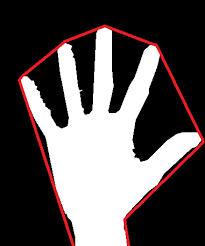